# Breast Cancer Classification

In [1]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils import data

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
from os import path
import pandas as pd
from collections import defaultdict
from skimage import io, transform

In [4]:
from PIL import Image
import os.path

In [5]:
import tensorflow as tf
from PIL import Image
import numpy as np
import cv2
import glob

/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [6]:
rootdir = '/Users/yingyinxiao/breast_cancer'
path_malignant = '/data/malignant'
path_benign = '/data/benign'

### Create the CSV file
- png name with directory
- pixel numbers
- categories
- 1/0

In [82]:
os.listdir()

['untitled folder',
 '.DS_Store',
 'csv.csv',
 'Yingyin.ipynb',
 'README.md',
 '.ipynb_checkpoints',
 '.git']

In [120]:
dic4csv = defaultdict(list)

In [121]:
index = 0
for root, dirs, files in os.walk(rootdir):
    for file in files:
        if file.endswith(".png"):
            full_path = ''
            values = root.split('/')
            ordered = [x for x in values if x]
            ordered.append(file)
            
            for i in ordered:
                full_path+='/'+i

            dic4csv[index] = [values[-2], values[-3], values[-4], values[-1], index, full_path]
            index +=1

In [123]:
csv = pd.DataFrame(data = dic4csv).transpose().rename(columns = {0: 'img_name', 1: 'category', 2: 'binary',\
                                                                 3: 'img_size', 4: 'label', 5: 'full_path'})
csv.head()

,img_name,category,binary,img_size,label,full_path
0,SOB_M_MC_14-13418DE,mucinous_carcinoma,malignant,100X,0,/Users/yingyinxiao/breast_cancer/data/malignan...
1,SOB_M_MC_14-13418DE,mucinous_carcinoma,malignant,400X,1,/Users/yingyinxiao/breast_cancer/data/malignan...
2,SOB_M_MC_14-13418DE,mucinous_carcinoma,malignant,400X,2,/Users/yingyinxiao/breast_cancer/data/malignan...
3,SOB_M_MC_14-13418DE,mucinous_carcinoma,malignant,400X,3,/Users/yingyinxiao/breast_cancer/data/malignan...
4,SOB_M_MC_14-13418DE,mucinous_carcinoma,malignant,400X,4,/Users/yingyinxiao/breast_cancer/data/malignan...


In [122]:
pd.DataFrame(data = dic4csv).transpose()[5][0]

'/Users/yingyinxiao/breast_cancer/data/malignant/mucinous_carcinoma/SOB_M_MC_14-13418DE/100X/SOB_M_MC-14-13418DE-100-002.png'

In [124]:
csv['img_name'] = csv['img_name'] +'_'+ csv['img_size']
csv['img_name']

0       SOB_M_MC_14-13418DE_100X
1       SOB_M_MC_14-13418DE_400X
2       SOB_M_MC_14-13418DE_400X
3       SOB_M_MC_14-13418DE_400X
4       SOB_M_MC_14-13418DE_400X
                  ...           
3878    SOB_B_PT_14-29315EF_200X
3879    SOB_B_PT_14-29315EF_200X
3880    SOB_B_PT_14-29315EF_200X
3881    SOB_B_PT_14-29315EF_200X
3882    SOB_B_PT_14-29315EF_200X
Name: img_name, Length: 3883, dtype: object

In [125]:
def helper(row):
    if row == 'malignant':
        return 1
    else: return 0

In [126]:
csv['binary'] = csv['binary'].apply(helper)

In [127]:
csv.binary.value_counts()

0    2490
1    1393
Name: binary, dtype: int64

In [128]:
csv.to_csv('csv.csv')

In [129]:
index == csv.shape[0]

True

### Early exploration

In [10]:
csv = pd.read_csv('csv.csv').drop('Unnamed: 0', axis = 1)

In [12]:
csv.describe()

,binary,label
count,3883.000000,3883.000000
mean,0.358743,1941.000000
std,0.479693,1121.069876
min,0.000000,0.000000
25%,0.000000,970.500000
50%,0.000000,1941.000000
75%,1.000000,2911.500000
max,1.000000,3882.000000


In [13]:
csv.groupby(['binary', 'img_size']).count()

img_name  category  label  full_path
binary img_size                                      
0      100X           648       648    648        648
       200X           623       623    623        623
       400X           594       594    594        594
       40X            625       625    625        625
1      100X           395       395    395        395
       200X           367       367    367        367
       400X           288       288    288        288
       40X            343       343    343        343

Text(0.5, 1.0, 'Bar Chart of Benign and Malignant Cases')

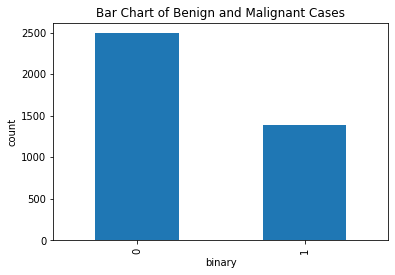

In [14]:
fig, ax = plt.subplots()    
csv.groupby('binary')['img_name'].count().plot.bar()
plt.ylabel('count')
plt.title('Bar Chart of Benign and Malignant Cases')

The binary data is obviously imbalanced, which will be adjusted later. There are more benigh than malignant images.

In [15]:
b1 = list(csv[csv.binary == 1].img_size.value_counts())
b0 = list(csv[csv.binary == 0].img_size.value_counts())
b1, b0

([395, 367, 343, 288], [648, 625, 623, 594])

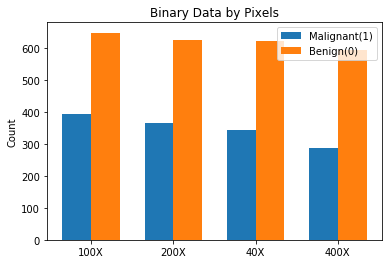

In [16]:
N = 4

ind = np.arange(N) 
width = 0.35       
plt.bar(ind, b1, width, label='Malignant(1)')
plt.bar(ind + width, b0, width,
    label='Benign(0)')

plt.ylabel('Count')
plt.title('Binary Data by Pixels')

plt.xticks(ind + width / 2, ('100X', '200X', '40X', '400X'))
plt.legend(loc='upper right')
plt.show()

In [17]:
csv.groupby(['binary', 'category']).describe()

label                                       \
                             count    mean         std     min      25%   
binary category                                                           
0      adenosis              444.0  1614.5  128.316016  1393.0  1503.75   
       fibroadenoma         1024.0  2917.5  295.747640  2406.0  2661.75   
       phyllodes_tumor       453.0  3656.0  130.914094  3430.0  3543.00   
       tubular_adenoma       569.0  2121.0  164.400426  1837.0  1979.00   
1      ductal_carcinoma      991.0   785.0  286.221360   290.0   537.50   
       lobular_carcinoma     112.0  1336.5   32.475632  1281.0  1308.75   
       mucinous_carcinoma    150.0    74.5   43.445368     0.0    37.25   
       papillary_carcinoma   140.0   219.5   40.558600   150.0   184.75   

                                                     
                               50%      75%     max  
binary category                                      
0      adenosis             1614.5  1725.25  1836.0  
       fibroadenoma         2917.5  3173.25  3429.0  
       phyllodes_tumor      3656.0  3769.00  3882.0  
       tubular_adenoma      2121.0  2263.00  2405.0  
1      ductal_carcinoma      785.0  1032.50  1280.0  
       lobular_carcinoma    1336.5  1364.25  1392.0  
       mucinous_carcinoma     74.5   111.75   149.0  
       papillary_carcinoma   219.5   254.25   289.0

In [18]:
b1_ = (csv[csv.binary == 1].category.value_counts())
category1 = list(csv[csv.binary == 1].category.value_counts().index)
b0_ = (csv[csv.binary == 0].category.value_counts())
category0 = list(csv[csv.binary == 0].category.value_counts().index)

([<matplotlib.axis.XTick at 0x1a4787acd0>,
 <a list of 4 Text xticklabel objects>)

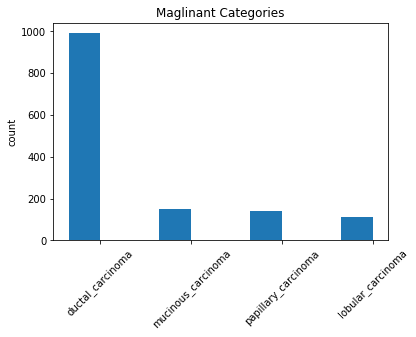

In [19]:
plt.bar(ind, b1_, width)
plt.ylabel('count')
plt.title('Maglinant Categories')
plt.xticks(ind + width / 2, category1, rotation = 45)

([<matplotlib.axis.XTick at 0x1a47d354d0>,
 <a list of 4 Text xticklabel objects>)

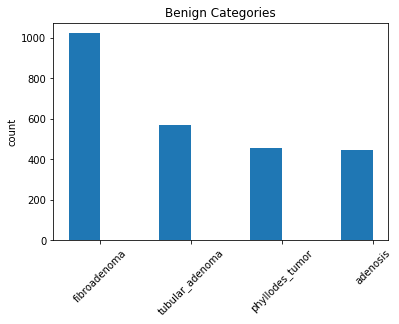

In [20]:
plt.bar(ind, b0_, width)
plt.ylabel('count')
plt.title('Benign Categories')
plt.xticks(ind + width / 2, category0, rotation = 45)

### Data loader

In [180]:
csv.head()

,img_name,category,binary,img_size,label,full_path
0,SOB_M_MC_14-13418DE_100X,mucinous_carcinoma,1,100X,0,/Users/yingyinxiao/breast_cancer/data/malignan...
1,SOB_M_MC_14-13418DE_400X,mucinous_carcinoma,1,400X,1,/Users/yingyinxiao/breast_cancer/data/malignan...
2,SOB_M_MC_14-13418DE_400X,mucinous_carcinoma,1,400X,2,/Users/yingyinxiao/breast_cancer/data/malignan...
3,SOB_M_MC_14-13418DE_400X,mucinous_carcinoma,1,400X,3,/Users/yingyinxiao/breast_cancer/data/malignan...
4,SOB_M_MC_14-13418DE_400X,mucinous_carcinoma,1,400X,4,/Users/yingyinxiao/breast_cancer/data/malignan...


In [177]:
csv.shape

(3883, 6)

In [103]:
labels = dict(zip(csv['img_name'], csv['label']))

In [33]:
csv_path = 'Users⁩/⁨yingyinxiao⁩/⁨breast_cancer⁩/⁨Breast-Cancer-Classification⁩/csv.csv'
root_dir = "Users/⁨yingyinxiao⁩/⁨breast_cancer⁩/data⁨"

In [251]:
class DataLoader(data.Dataset):
    """
    Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    def __init__(self, csv_file, transform = None):
        'Initialization'
        self.frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.frame)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        img_name = self.frame.iloc[index, 6]
        image = io.imread(img_name)
        
        label = self.frame.iloc[index, 3]
        # Load data and get label
         
        sample = {'image': image, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [255]:
def get_loader(dataset, param):
    
    samples = DataLoader(dataset)
    matrixes = []
    matrixes = [matrixes.append(x['image']) for x in samples]
    
    targets = []
    matrixes = [matrixes.append(x['label']) for x in samples]
    
    
    X_train, X_test, y_train, y_test = train_test_split(matrixes, target, test_size = param, random_state=1)
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = param, random_state=1)
    
    train = [X_train, y_train]
    val = [X_val, y_val]
    test = [X_test, y_test]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

### Iterate through some images

In [26]:
from DataLoader import Dataset

NameError: name 'data' is not defined

In [27]:
dataset = Dataset('csv.csv')

NameError: name 'Dataset' is not defined

In [23]:
import time

In [24]:
fig = plt.figure()

for i in range(len(dataset)):
    sample = dataset[i]
    print(i, sample['image'].shape, sample['label'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])

    if i == 3:
        plt.show()
        break

NameError: name 'dataset' is not defined

<Figure size 432x288 with 0 Axes>

### See if the images are in the same size

In [ ]:
filename = os.path.join()
img = Image.open(filename)
print(img.size)